In [2]:
import pandas as pd
import json
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
# import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

plotly.offline.init_notebook_mode(connected=True) 

%matplotlib inline

In [3]:
def read_formatted_jsons(INDIR):
    generation_dfs = []
    stats_dicts = []
    
    for domain in os.listdir(INDIR):
        for fname in glob.glob(INDIR+domain+"/*.json"):

            org_id = os.path.basename(fname).strip(".json")

            with open(fname) as f:
                datajson = json.load(f)

            datajson["stats"]["org_id"] = org_id
            datajson["stats"]["domain"] = domain
            datajson["stats"]["path"] = fname

            stats_dicts.append(datajson["stats"])
            generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

In [4]:
def read_formatted_json_single(INDIR):
    generation_dfs = []
    stats_dicts = []
    
#     for domain in os.listdir(INDIR):
    for fname in glob.glob(INDIR+"*.json"):

        org_id = os.path.basename(fname).strip(".json")

        with open(fname) as f:
            datajson = json.load(f)

        datajson["stats"]["org_id"] = org_id
        datajson["stats"]["domain"] = domain
        datajson["stats"]["path"] = fname

        stats_dicts.append(datajson["stats"])
        generation_dfs.append(pd.DataFrame(datajson["generations"]))
            
    return generation_dfs, stats_dicts

### Transpose etc.

In [5]:
def twist_dfs(df_list):
    twisted_dfs = []
    for df in df_list:
        df = df.transpose()
        df.index = df.index.astype(int)
        df = df.sort_index()   
        twisted_dfs.append(df)
    return twisted_dfs

### Add `n` columns

In [6]:
def add_n_to_cols(df_list):
    for df in df_list:
        original_columns = df.columns
        for col in original_columns:
            df["n_"+col] = df[col].str.len() 
    return df_list

### Add domain and org_id

In [7]:
def add_domain_and_orgid(df_list,stats_dicts):
    for i,df in enumerate(df_list):
        df['org_id'] = stats_dicts[i]["org_id"]
        df['domain'] = stats_dicts[i]["domain"]
    return df_list

### Add tags if desired

In [8]:
def add_tags(df_list,cpds_to_tag):
    for df in df_list:
        df['tags'] = df['compounds_new'].apply(lambda x: [cpd for cpd in cpds_to_tag if cpd in x])
    return df_list

In [9]:
def cool_plots_many(df,attribute):
    traces = []
    for i in df["org_id"].unique():
        
        traces.append(go.Scatter(
        x = df.loc[df["org_id"]==i].index,
        y = df.loc[df["org_id"]==i][attribute],
        mode = 'lines+markers',
        name = attribute
        ))
    plotly.offline.iplot(traces)   

In [10]:
def cool_plots(df,line1,line2):

    # Create traces
    trace0 = go.Scatter(
        x = df.index,
        y = df[line1],
        mode = 'lines+markers+text',
        name = line1,
        textposition='top center'
    #     text= data['state']
    )
    trace1 = go.Scatter(
        x = df.index,
        y = df[line2],
        mode = 'lines+markers',
        name = line2
    )

    data = [trace0,trace1]
    plotly.offline.iplot(data)

### Main

In [11]:
cpds_to_tag = []

INDIR = "../results/formatted/ph_edge_jsons/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

In [12]:
len(df.groupby("org_id").max())

294

In [13]:
stats_dicts[0].keys()

dict_keys(['scope_targets', 'scope_reactions', 'scope_compounds', 'scope_seeds', 'org_id', 'domain', 'path'])

## Use stats df and regular df to compile data into sinlge dataframe

In [14]:
stats_df = pd.DataFrame(stats_dicts)

In [15]:
for col in ['scope_targets','scope_compounds']:
    stats_df["n_"+col] = stats_df[col].str.len() 

In [16]:
max_df = df.groupby("org_id").max()

In [17]:
merged_df = pd.merge(max_df.reset_index()[["n_compounds_cumulative","n_targets_cumulative","org_id","domain"]],
        stats_df[["org_id","n_scope_targets","n_scope_compounds"]],
        on="org_id")

In [18]:
merged_df = merged_df.sort_values(["domain","n_scope_compounds"],ascending=False)

In [19]:
merged_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds
156,19,0,2554235157,bacteria,60,1861
28,17,0,2517287020,bacteria,60,1809
21,17,0,2515154141,bacteria,60,1786
20,16,0,2515154140,bacteria,60,1767
277,25,0,640753051,bacteria,60,1701


In [20]:
merged_df_nophosphorous = merged_df

In [21]:
merged_df_nophosphorous['P'] = False

In [22]:
merged_df_nophosphorous.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P
156,19,0,2554235157,bacteria,60,1861,False
28,17,0,2517287020,bacteria,60,1809,False
21,17,0,2515154141,bacteria,60,1786,False
20,16,0,2515154140,bacteria,60,1767,False
277,25,0,640753051,bacteria,60,1701,False


### Barplots

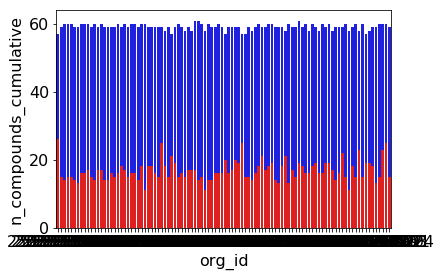

In [269]:
# Plot the total crashes
# sns.set_color_codes("pastel")
sns.barplot(x="org_id", y="n_scope_targets", data=merged_df[:100],
            label="Total network size", color="b")

# Plot the crashes where alcohol was involved
# sns.set_color_codes("muted")
sns.barplot(x="org_id", y="n_compounds_cumulative", data=merged_df[:100],
            label="Alcohol-involved", color="r")


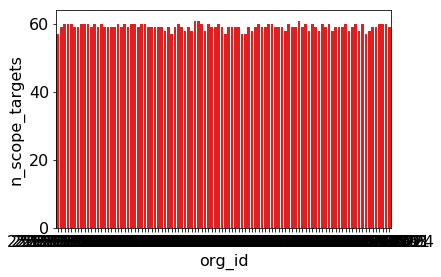

In [270]:
sns.barplot(x="org_id", y="n_scope_targets", data=merged_df[:100],
            label="Alcohol-involved", color="r")

In [233]:
generation_dfs[0][["n_compounds_cumulative","n_targets_cumulative","org_id","domain"]]

,n_compounds_cumulative,n_targets_cumulative,org_id,domain
1,10,0,2506520044,archaea
2,15,0,2506520044,archaea
3,17,0,2506520044,archaea
4,18,0,2506520044,archaea


### Properties of the organisms I ended up analyzing

In [23]:
len(stats_dicts[0].keys())

7

In [24]:
generation_dfs[0].head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C00014, C00011, C00282, C00469, C0028...","[C00282, C00237, C00014, C00011, C00067, C0143...","[R10092, R00602, R00132]","[R00132, R00602, R10092]",[],[],10,10,3,3,0,0,2593339207,bacteria
2,"[C00080, C00001, C00014, C00288, C00011, C0028...","[C00080, C00288, C00027, C01353]","[R10092, R00602, R00132, R00009]",[R00009],[],[],14,4,4,1,0,0,2593339207,bacteria
3,"[C00080, C00001, C00014, C00288, C00011, C0000...",[C00007],"[R10092, R00602, R00132, R00009]",[],[],[],15,1,4,0,0,0,2593339207,bacteria


In [26]:
for k in ['scope_targets','scope_compounds']:
    print(len(stats_dicts[0][k]))
    print(len(generation_dfs[0]))

59
3
1103
3


In [27]:
stats_dicts[0].keys()

dict_keys(['scope_targets', 'scope_reactions', 'scope_compounds', 'scope_seeds', 'org_id', 'domain', 'path'])

In [28]:
len(stats_dicts)-28

266

### Look at some properties of stats dicts

(array([  2.,   0.,   2.,  13.,  46., 173.,  23.,  12.,  14.,   9.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <a list of 10 Patch objects>)

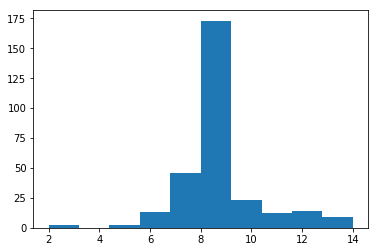

In [29]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([  1.,   0.,   0.,   1.,   2.,   4.,   8.,  19., 107., 152.]),
 array([32. , 34.9, 37.8, 40.7, 43.6, 46.5, 49.4, 52.3, 55.2, 58.1, 61. ]),
 <a list of 10 Patch objects>)

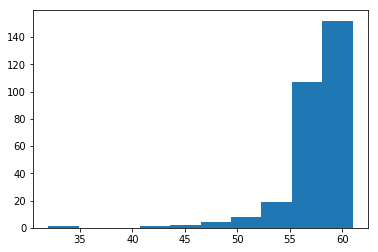

In [30]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([ 2.,  0.,  4., 15., 28., 64., 80., 71., 25.,  5.]),
 array([ 161.,  331.,  501.,  671.,  841., 1011., 1181., 1351., 1521.,
        1691., 1861.]),
 <a list of 10 Patch objects>)

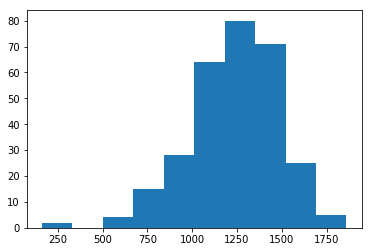

In [31]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([ 2.,  2.,  7.,  8., 26., 67., 64., 80., 33.,  5.]),
 array([  85. ,  247.2,  409.4,  571.6,  733.8,  896. , 1058.2, 1220.4,
        1382.6, 1544.8, 1707. ]),
 <a list of 10 Patch objects>)

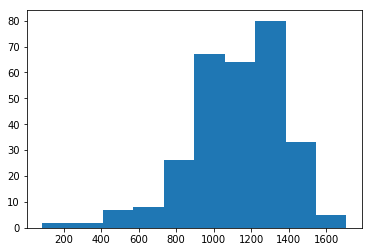

In [32]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

(array([  2.,   7.,  28.,  16.,  36., 134.,  39.,  21.,   7.,   4.]),
 array([ 2. ,  4.4,  6.8,  9.2, 11.6, 14. , 16.4, 18.8, 21.2, 23.6, 26. ]),
 <a list of 10 Patch objects>)

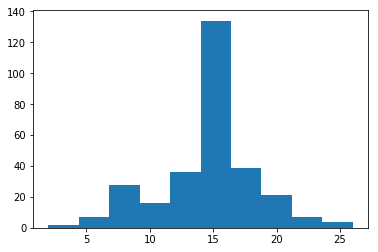

In [33]:
plt.hist([merged_df["n_compounds_cumulative"]])

(array([  2.,   7.,  28.,  16.,  36., 134.,  39.,  21.,   7.,   4.]),
 array([ 2. ,  4.4,  6.8,  9.2, 11.6, 14. , 16.4, 18.8, 21.2, 23.6, 26. ]),
 <a list of 10 Patch objects>)

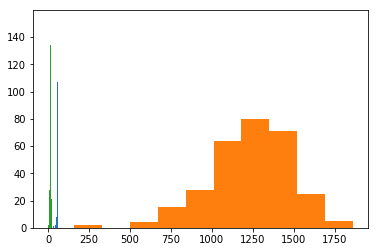

In [34]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])
plt.hist([len(d['scope_compounds']) for d in stats_dicts])
plt.hist([merged_df["n_compounds_cumulative"]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1282cf1d0>,
      dtype=object)

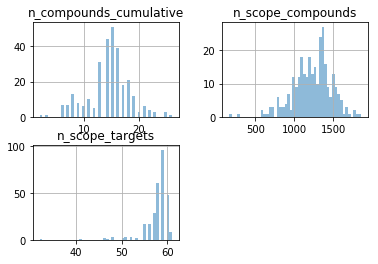

In [35]:
merged_df[['n_compounds_cumulative','n_scope_targets','n_scope_compounds']].hist(alpha=.5,bins=50)

## Font properties

In [195]:
color_order = ['blue' if domain=='bacteria' else 'orange' for domain in df["domain"]]


In [196]:
df["color"] = color_order

In [197]:
font = {'size'   : 16}
# 'family' : 'normal',
#         'weight' : 'bold',
       

mpl.rc('font', **font)

In [36]:
len(stats_dicts)

294

stats_dicts[0]

In [37]:
# stats_dicts[0]

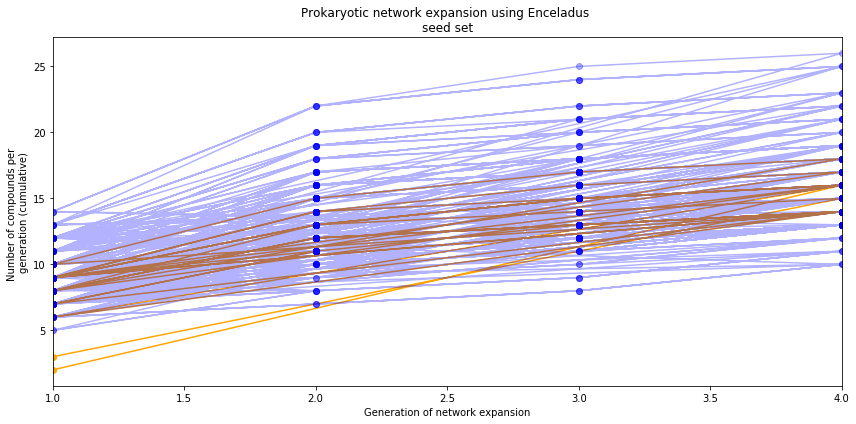

In [38]:
# plt.figure(facecolor='w')
ax = df.loc[df["domain"]=="archaea"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="orange",figsize=(12,6),legend=False)
df.loc[df["domain"]=="bacteria"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="blue",ax=ax, alpha=.3,legend=False)

ax.set_facecolor("white")
ax.set_title("Prokaryotic network expansion using Enceladus \nseed set")
ax.set_xlabel("Generation of network expansion")
ax.set_ylabel("Number of compounds per \ngeneration (cumulative)")
plt.tight_layout()

# plt.legend(False)


In [39]:
# cool_plots_many(df,'n_compounds_cumulative')

## Check seeds that contain phosphorous

In [40]:
INDIR = "../results/formatted/ph_edge_jsons_P/"

generation_dfs, stats_dicts = read_formatted_jsons(INDIR)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = pd.concat(generation_dfs)

### Make merged df of phosphorous data

In [41]:
stats_df = pd.DataFrame(stats_dicts)

In [42]:
for col in ['scope_targets','scope_compounds']:
    stats_df["n_"+col] = stats_df[col].str.len() 

In [43]:
max_df = df.groupby("org_id").max()

In [44]:
merged_df = pd.merge(max_df.reset_index()[["n_compounds_cumulative","n_targets_cumulative","org_id","domain"]],
        stats_df[["org_id","n_scope_targets","n_scope_compounds"]],
        on="org_id")

In [45]:
merged_df = merged_df.sort_values(["domain","n_scope_compounds"],ascending=False)

In [46]:
merged_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds
156,22,0,2554235157,bacteria,60,1861
28,19,0,2517287020,bacteria,60,1809
21,19,0,2515154141,bacteria,60,1786
20,18,0,2515154140,bacteria,60,1767
277,28,0,640753051,bacteria,60,1701


In [47]:
merged_df_phosphorous = merged_df

In [48]:
merged_df_phosphorous['P'] = True

In [49]:
merged_df_phosphorous.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P
156,22,0,2554235157,bacteria,60,1861,True
28,19,0,2517287020,bacteria,60,1809,True
21,19,0,2515154141,bacteria,60,1786,True
20,18,0,2515154140,bacteria,60,1767,True
277,28,0,640753051,bacteria,60,1701,True


### Put P and no P dfs together

In [50]:
for col in merged_df_phosphorous.columns:
    merged_df_phosphorous.rename(columns={col: col+'_P'}, inplace=True)

In [51]:
merged_df_phosphorous.head()

,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
156,22,0,2554235157,bacteria,60,1861,True
28,19,0,2517287020,bacteria,60,1809,True
21,19,0,2515154141,bacteria,60,1786,True
20,18,0,2515154140,bacteria,60,1767,True
277,28,0,640753051,bacteria,60,1701,True


In [68]:
pnp_df = pd.merge(merged_df_nophosphorous,merged_df_phosphorous,left_on="org_id",right_on="org_id_P")

In [69]:
# pnp_df = pd.concat([merged_df_nophosphorous,merged_df_phosphorous])

In [70]:
pnp_df.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
0,19,0,2554235157,bacteria,60,1861,False,22,0,2554235157,bacteria,60,1861,True
1,17,0,2517287020,bacteria,60,1809,False,19,0,2517287020,bacteria,60,1809,True
2,17,0,2515154141,bacteria,60,1786,False,19,0,2515154141,bacteria,60,1786,True
3,16,0,2515154140,bacteria,60,1767,False,18,0,2515154140,bacteria,60,1767,True
4,25,0,640753051,bacteria,60,1701,False,28,0,640753051,bacteria,60,1701,True


In [71]:
# pnp_df.rename(columns={'n_compounds_cumulative': 'No P', 'n_compounds_cumulative_P': 'P'}, inplace=True)

### New version of figure attempted below...

In [73]:
orgid_domain_dict = dict(pnp_df.groupby("org_id").min()["domain"])

In [72]:
orgid_rank_order = [org for org in pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().keys()]


In [74]:
color_rank_order = ['blue' if domain=='bacteria' else 'orange' for domain in [orgid_domain_dict[org] for org in orgid_rank_order]]


Text(0, 0.5, 'Number of compounds')

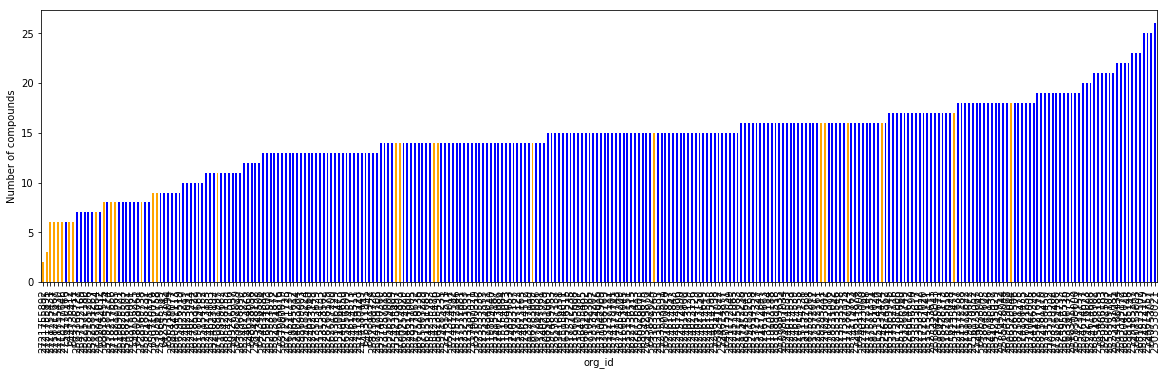

In [79]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
ax = pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().plot(kind="bar",figsize=(20,5),color=color_rank_order)
ax.set_ylabel("Number of compounds")

Text(0, 0.5, 'Number of compounds')

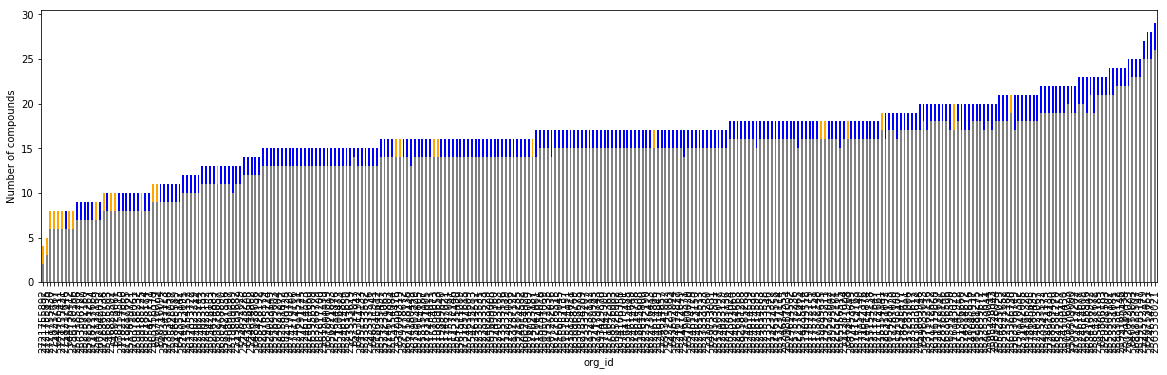

In [150]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().plot(kind="bar",figsize=(20,5),color=color_rank_order)
pnp_df.groupby("org_id").min()["n_compounds_cumulative"].reindex(pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().index).plot(kind="bar",figsize=(20,5),ax=ax,color="gray")

ax.set_ylabel("Number of compounds")


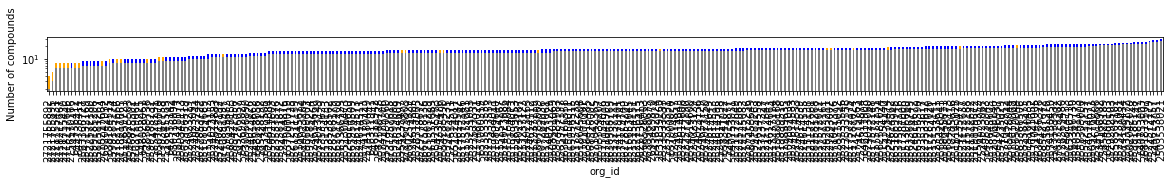

In [97]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
# plt.figure(figsize=(20,1))
ax = pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().plot(kind="bar",figsize=(20,1),color=color_rank_order)
pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().plot(kind="bar",ax=ax,color="gray")
ax.set_ylabel("Number of compounds")
ax.set_yscale("log")



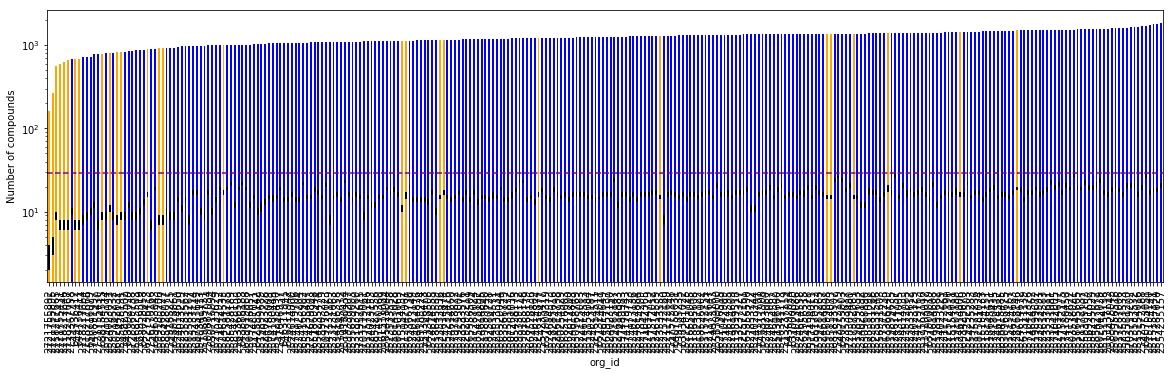

In [152]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color=color_rank_order)
pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index).plot(kind="bar",ax=ax,color="black")
pnp_df.groupby("org_id").min()["n_compounds_cumulative"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index).plot(kind="bar",ax=ax,color=color_rank_order,alpha=1)
ax.axhline(y=max(pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values()),color="purple",linestyle="--")#, xmin=0, xmax=1)
ax.set_ylabel("Number of compounds")
ax.set_yscale("log")


In [142]:
pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values()

org_id
2721755892     161
2721755895     269
2718217665     569
2721755431     598
2718217646     623
2718217667     657
2739367758     679
644736412      680
644736411      690
2718217664     723
2718217666     727
650716079      730
2740891997     780
2721755430     789
638154515      790
2599185174     799
2524023091     800
2599185232     801
2602042032     817
2585428191     824
2546825502     829
643692029      850
2728369738     854
2546825503     873
2565956519     876
648028058      882
2622736413     897
2756170166     905
649633043      910
2599185206     916
              ... 
2523231081    1523
2571042005    1524
2524614677    1525
2517572175    1526
2574180450    1530
2521172622    1532
2503538021    1533
2518645605    1543
2521172637    1549
2558309102    1557
2556921652    1560
2554235029    1565
2585427672    1567
2602042029    1574
2515154138    1574
2513237112    1576
2585428043    1589
2565956516    1592
2517287006    1593
2523533533    1594
2582581270    1596
27037

In [147]:
pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index

Index(['2721755892', '2721755895', '2718217665', '2721755431', '2718217646',
       '2718217667', '2739367758', '644736412', '644736411', '2718217664',
       ...
       '2582581270', '2703719202', '2523533532', '2515154016', '2522572188',
       '640753051', '2515154140', '2515154141', '2517287020', '2554235157'],
      dtype='object', name='org_id', length=294)

### series aren't lined up after sorting, have to reindex
### let's instead plot percentages

In [155]:
cpd_scope = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values()

In [153]:
cpd_cum = pnp_df.groupby("org_id").min()["n_compounds_cumulative"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index)


In [154]:
cpd_cump = pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].reindex(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().index)


In [157]:
(cpd_cum/cpd_scope).sort_values()

org_id
2522572180    0.005397
2547132169    0.006404
2756170166    0.006630
2582581267    0.007136
2703719061    0.007227
2524023244    0.007446
2627853722    0.007446
2563366727    0.007600
2721755430    0.007605
2599185206    0.007642
2519899682    0.007779
2518645589    0.007806
2630968890    0.007971
2524023192    0.007971
2519899721    0.008089
648028061     0.008556
2599185225    0.008565
2602042032    0.008568
2561511139    0.008649
644736411     0.008696
2524614883    0.008703
642555142     0.008798
644736412     0.008824
2515154152    0.008850
2515154133    0.008886
2515154016    0.008982
650716094     0.009036
2515154140    0.009055
2540341113    0.009119
2718217667    0.009132
                ...   
2554235474    0.014733
2506520044    0.015025
2516143028    0.015098
2651869948    0.015755
2524614533    0.016032
2585428044    0.016071
2509887034    0.016097
2687453649    0.016211
2513237114    0.016227
2622736413    0.016722
640753003     0.016727
2563366730    0.016784
2681

In [158]:
(cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index)

org_id
2522572180    0.006939
2547132169    0.008234
2756170166    0.008840
2582581267    0.009174
2703719061    0.009033
2524023244    0.008935
2627853722    0.008935
2563366727    0.009772
2721755430    0.010139
2599185206    0.009825
2519899682    0.009194
2518645589    0.009540
2630968890    0.009420
2524023192    0.009420
2519899721    0.010111
648028061     0.010695
2599185225    0.010707
2602042032    0.011016
2561511139    0.009980
644736411     0.011594
2524614883    0.010285
642555142     0.010753
644736412     0.011765
2515154152    0.010619
2515154133    0.010253
2515154016    0.010180
650716094     0.011044
2515154140    0.010187
2540341113    0.011145
2718217667    0.012177
                ...   
2554235474    0.016575
2506520044    0.016694
2516143028    0.017762
2651869948    0.018536
2524614533    0.018036
2585428044    0.017857
2509887034    0.018109
2687453649    0.018237
2513237114    0.018256
2622736413    0.018952
640753003     0.018182
2563366730    0.018551
2681

#### relevant: https://stackoverflow.com/questions/21912197/setting-different-error-bar-colors-in-bar-plot-in-matplotlib

Text(0, 0.5, 'Fraction of scope compounds')

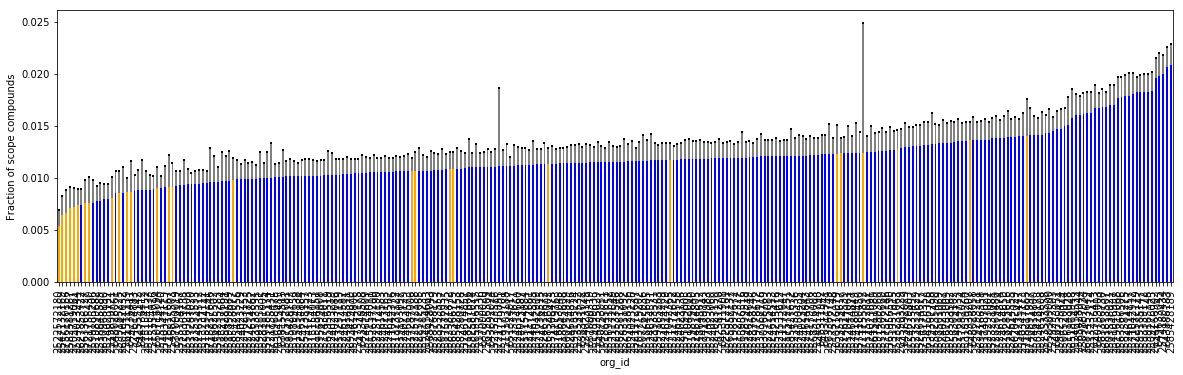

In [172]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = (cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),figsize=(20,5),color="gray")
ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylabel("Fraction of scope compounds")


Text(0, 0.5, 'Number of scope compounds')

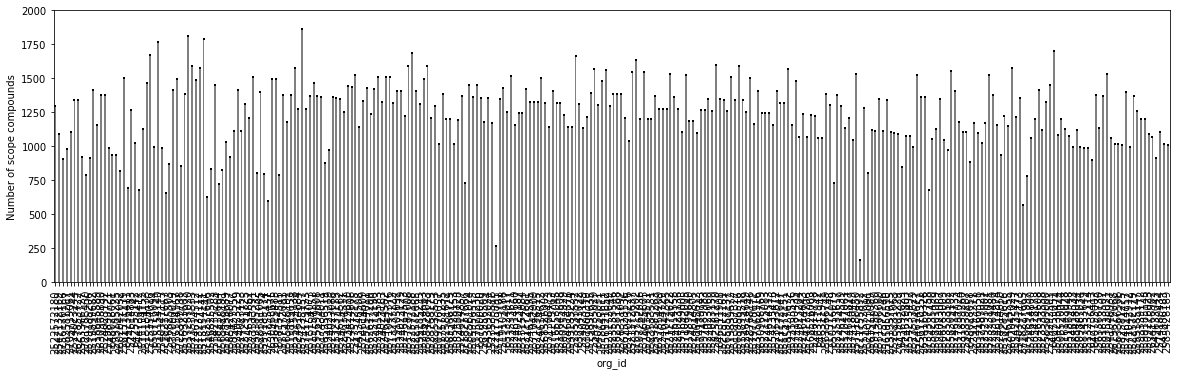

In [207]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = cpd_scope.reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),figsize=(20,5),color="gray")
# ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylim(0,2000)
ax.set_ylabel("Number of scope compounds")


In [182]:
cpd_scope

org_id
2721755892     161
2721755895     269
2718217665     569
2721755431     598
2718217646     623
2718217667     657
2739367758     679
644736412      680
644736411      690
2718217664     723
2718217666     727
650716079      730
2740891997     780
2721755430     789
638154515      790
2599185174     799
2524023091     800
2599185232     801
2602042032     817
2585428191     824
2546825502     829
643692029      850
2728369738     854
2546825503     873
2565956519     876
648028058      882
2622736413     897
2756170166     905
649633043      910
2599185206     916
              ... 
2523231081    1523
2571042005    1524
2524614677    1525
2517572175    1526
2574180450    1530
2521172622    1532
2503538021    1533
2518645605    1543
2521172637    1549
2558309102    1557
2556921652    1560
2554235029    1565
2585427672    1567
2602042029    1574
2515154138    1574
2513237112    1576
2585428043    1589
2565956516    1592
2517287006    1593
2523533533    1594
2582581270    1596
27037

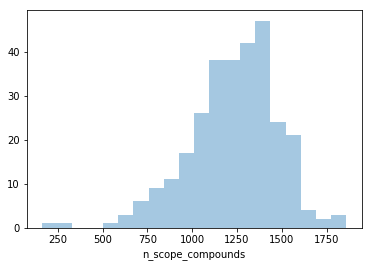

In [181]:
sns.distplot(cpd_scope,hist=True,kde=False)

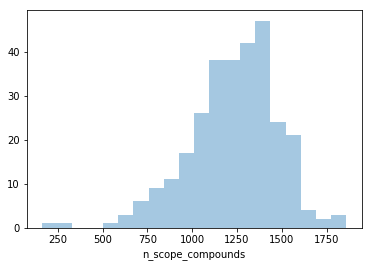

In [192]:
sns.distplot(pnp_df["n_scope_compounds"],hist=True,kde=False)

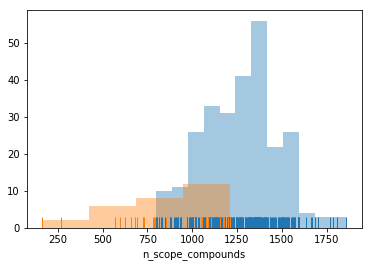

In [196]:
ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,rug=True)
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,rug=True,ax=ax)

In [203]:
[i for i in range(2050) if i%50==0]

[0,
 50,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000,
 1050,
 1100,
 1150,
 1200,
 1250,
 1300,
 1350,
 1400,
 1450,
 1500,
 1550,
 1600,
 1650,
 1700,
 1750,
 1800,
 1850,
 1900,
 1950,
 2000]

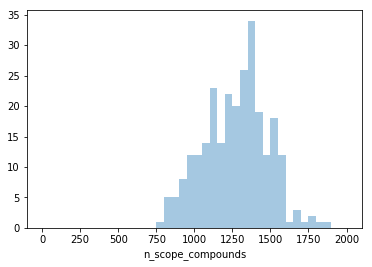

In [205]:
ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,bins=[i for i in range(2050) if i%50==0])


(0, 2000)

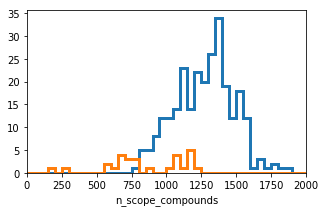

In [212]:
plt.figure(figsize=(5,3))
ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 3,"alpha":1})
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,ax=ax,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 3,"alpha":1})
ax.set_xlim(0,2000)


In [213]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

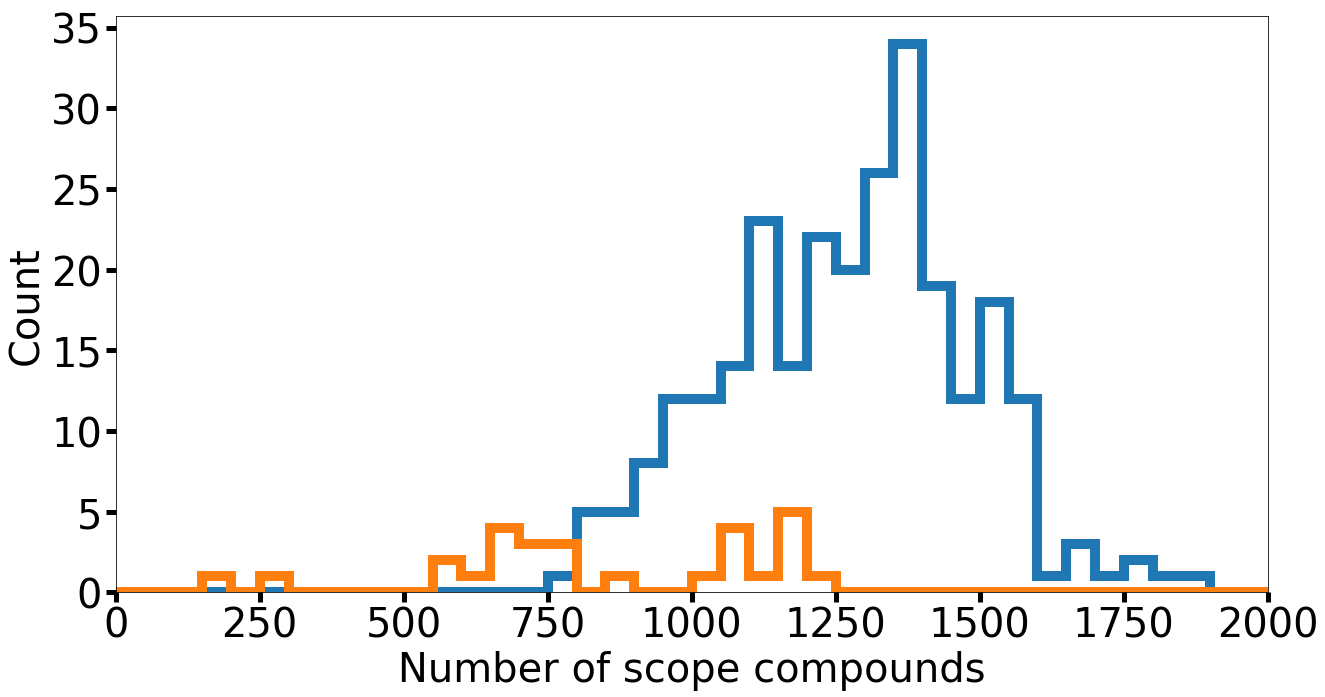

In [254]:
fig, ax=plt.subplots()

ax = sns.distplot(pnp_df.loc[pnp_df["domain"]=="bacteria"]["n_scope_compounds"],hist=True,kde=False,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 10,"alpha":1})
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,ax=ax,bins=[i for i in range(2050) if i%50==0],hist_kws={"histtype": "step","linewidth": 10,"alpha":1})
ax.set_xlim(0,2000)

set_size(16,8)
ax.set_xlabel("Number of scope compounds")
ax.set_ylabel("Count")

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)
ax.tick_params(axis='both', length=10,width=5)
plt.show()

Text(0, 0.5, 'Fraction of scope compounds')

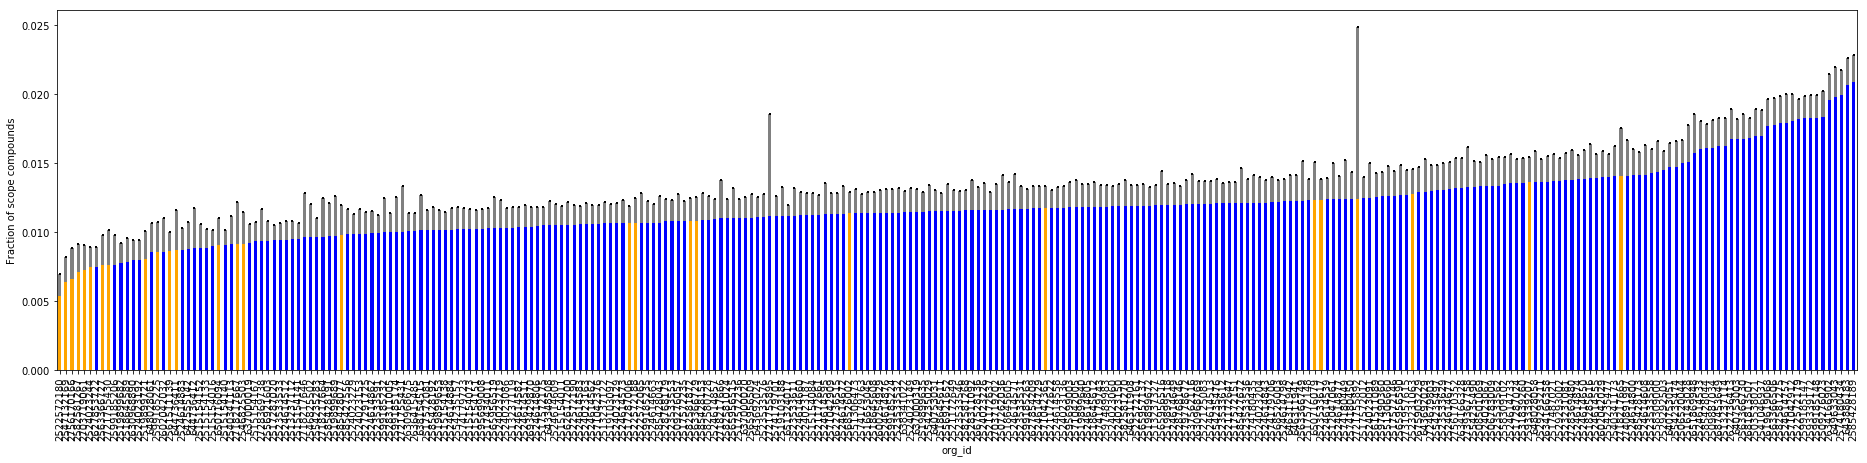

In [221]:
ax = (cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),color="gray")
ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

set_size(25,5)
ax.set_ylabel("Fraction of scope compounds")



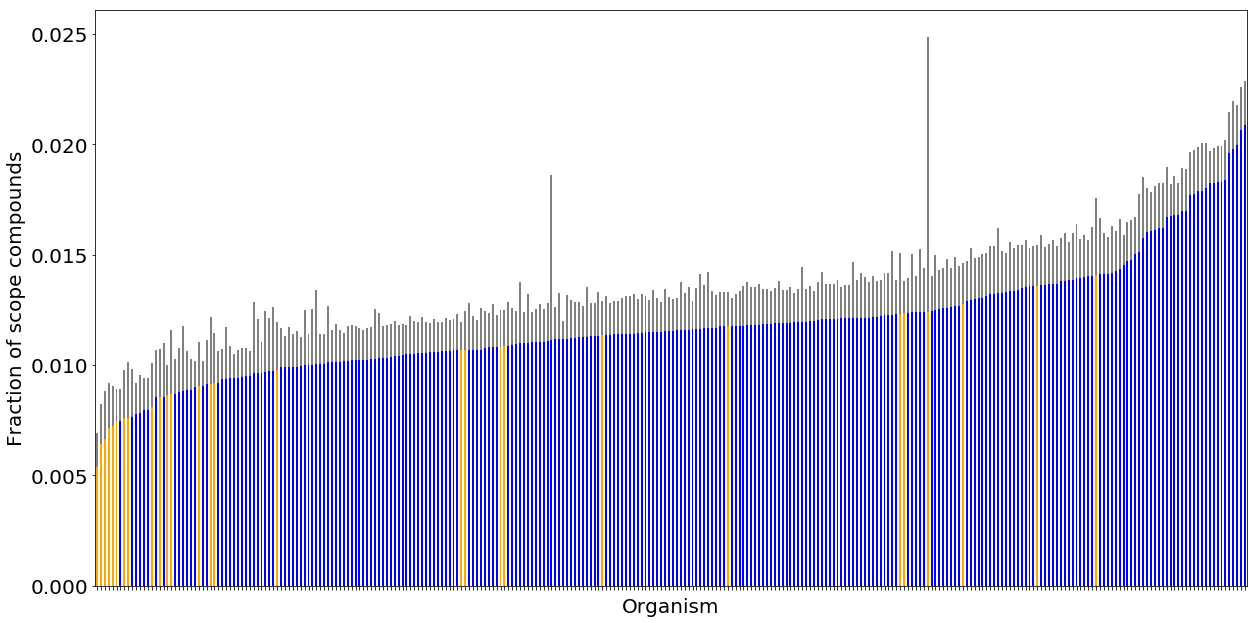

In [255]:
ax = (cpd_cump/cpd_scope).reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],width=.5,color="gray")
#error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=1),
ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",ax=ax,width=.5,color=color_rank_order)



set_size(16,8)
ax.set_ylabel("Fraction of scope compounds")
ax.set_xlabel("Organism")
ax.xaxis.set_major_formatter(plt.NullFormatter())
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)


Text(0, 0.5, 'Number of scope compounds')

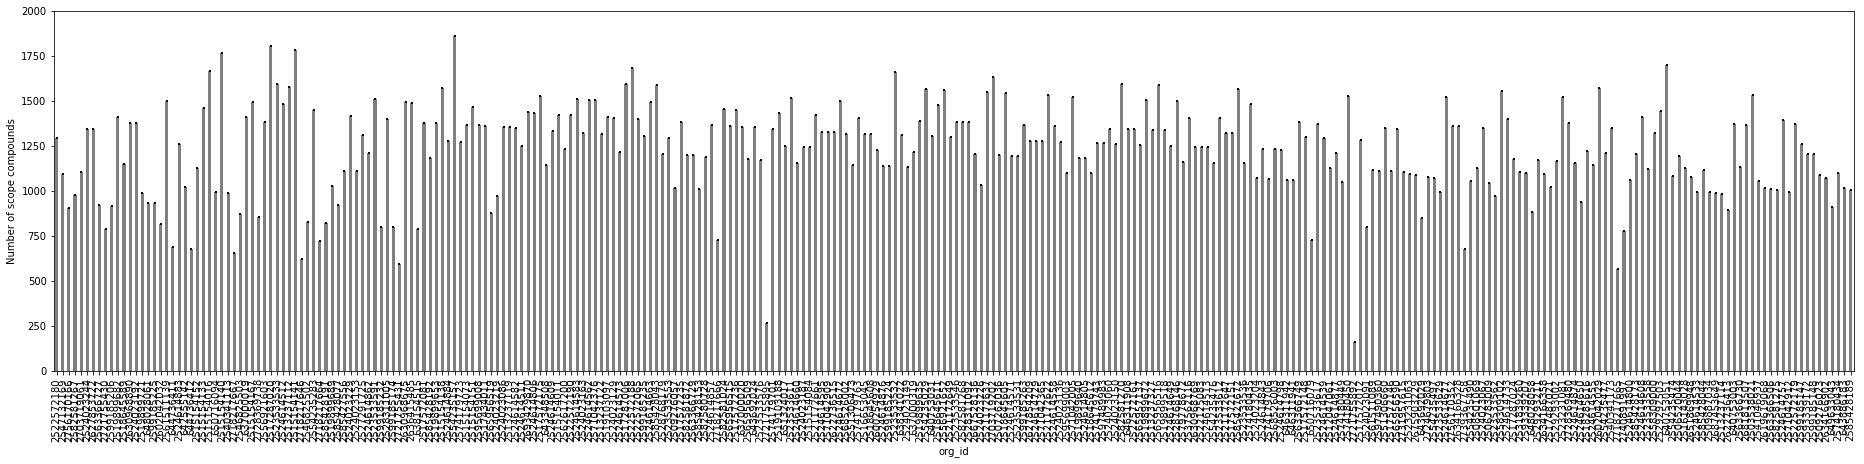

In [220]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = cpd_scope.reindex((cpd_cum/cpd_scope).sort_values().index).plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),color="gray")
# ax2 = (cpd_cum/cpd_scope).sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylim(0,2000)
set_size(25,5)
ax.set_ylabel("Number of scope compounds")


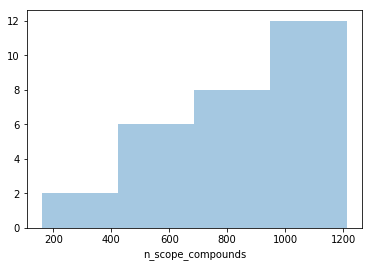

In [194]:
sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False)
# sns.distplot(pnp_df.loc[pnp_df["domain"]=="archaea"]["n_scope_compounds"],hist=True,kde=False,ax=ax)

In [189]:
len(pnp_df.loc[pnp_df["domain"]=="archaea"])

28

In [188]:
len(pnp_df.loc[pnp_df["domain"]=="bacteria"])

266

In [190]:
pnp_df.loc[pnp_df["domain"]=="bacteria"].head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P,n_compounds_cumulative_P,n_targets_cumulative_P,org_id_P,domain_P,n_scope_targets_P,n_scope_compounds_P,P_P
0,19,0,2554235157,bacteria,60,1861,False,22,0,2554235157,bacteria,60,1861,True
1,17,0,2517287020,bacteria,60,1809,False,19,0,2517287020,bacteria,60,1809,True
2,17,0,2515154141,bacteria,60,1786,False,19,0,2515154141,bacteria,60,1786,True
3,16,0,2515154140,bacteria,60,1767,False,18,0,2515154140,bacteria,60,1767,True
4,25,0,640753051,bacteria,60,1701,False,28,0,640753051,bacteria,60,1701,True


In [ ]:
ax = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,figsize=(8,4),legend=False)
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,legend=False)

ax.set_title("Histogram of number of compounds possible in \norganismal networks by domain",fontsize=16)
ax.set_xlabel("Number of compounds")

Text(0, 0.5, 'Fraction of scope compounds')

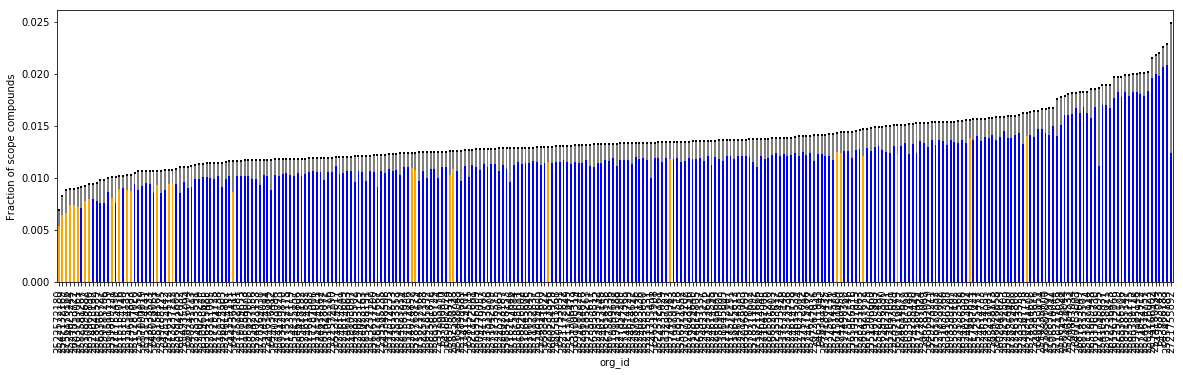

In [173]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(kind="bar",figsize=(20,5),color="gray")
ax = (cpd_cump/cpd_scope).sort_values().plot(kind="bar",yerr=[0 for i in range(len(cpd_cump))],error_kw=dict(ecolor="black", lw=2, capsize=1, capthick=2),figsize=(20,5),color="gray")
ax2 = (cpd_cum/cpd_scope).reindex((cpd_cump/cpd_scope).sort_values().index).plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)

ax.set_ylabel("Fraction of scope compounds")


#### testing if commands work...

In [119]:
myseries = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().transpose()

In [132]:
max(pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values())

29

In [125]:
myseries

org_id
2721755892     161
2721755895     269
2718217665     569
2721755431     598
2718217646     623
2718217667     657
2739367758     679
644736412      680
644736411      690
2718217664     723
2718217666     727
650716079      730
2740891997     780
2721755430     789
638154515      790
2599185174     799
2524023091     800
2599185232     801
2602042032     817
2585428191     824
2546825502     829
643692029      850
2728369738     854
2546825503     873
2565956519     876
648028058      882
2622736413     897
2756170166     905
649633043      910
2599185206     916
              ... 
2523231081    1523
2571042005    1524
2524614677    1525
2517572175    1526
2574180450    1530
2521172622    1532
2503538021    1533
2518645605    1543
2521172637    1549
2558309102    1557
2556921652    1560
2554235029    1565
2585427672    1567
2602042029    1574
2515154138    1574
2513237112    1576
2585428043    1589
2565956516    1592
2517287006    1593
2523533533    1594
2582581270    1596
27037

In [121]:
myseries_reversed = (pd.Series(myseries.index.values, index=myseries ))

In [123]:
myseries_reversed

n_scope_compounds
161     2721755892
269     2721755895
569     2718217665
598     2721755431
623     2718217646
657     2718217667
679     2739367758
680      644736412
690      644736411
723     2718217664
727     2718217666
730      650716079
780     2740891997
789     2721755430
790      638154515
799     2599185174
800     2524023091
801     2599185232
817     2602042032
824     2585428191
829     2546825502
850      643692029
854     2728369738
873     2546825503
876     2565956519
882      648028058
897     2622736413
905     2756170166
910      649633043
916     2599185206
           ...    
1523    2523231081
1524    2571042005
1525    2524614677
1526    2517572175
1530    2574180450
1532    2521172622
1533    2503538021
1543    2518645605
1549    2521172637
1557    2558309102
1560    2556921652
1565    2554235029
1567    2585427672
1574    2602042029
1574    2515154138
1576    2513237112
1589    2585428043
1592    2565956516
1593    2517287006
1594    2523533533
1596    25825

In [118]:
type(pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().transpose())

pandas.core.series.Series

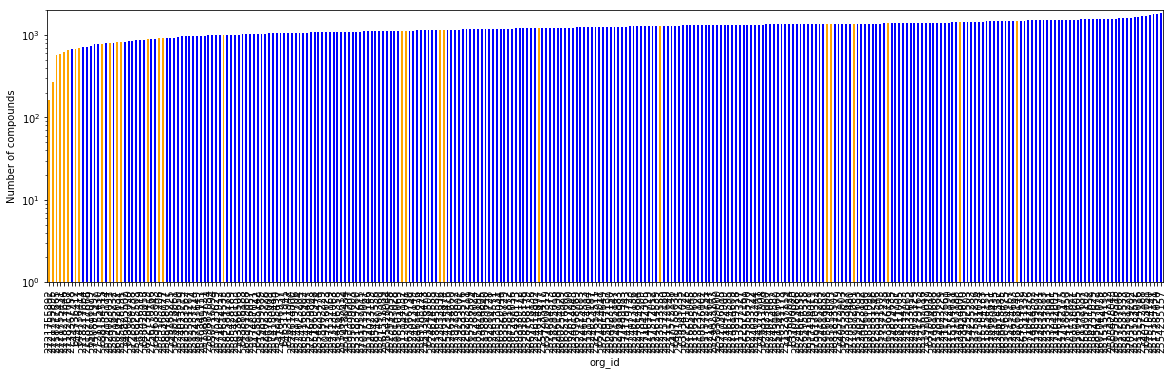

In [127]:
# ## bacteria=blue, archaea=orange
# ax = pnp_df.groupby("org_id").min()["n_seed_compounds"].sort_values().plot(kind="bar",figsize=(10,5),color=color_rank_order)
# ax.set_ylabel("Number of compounds in seed set")
## bacteria=blue, archaea=orange
ax = pnp_df.groupby("org_id").min()["n_scope_compounds"].sort_values().plot(y="org_id",kind="bar",figsize=(20,5),color=color_rank_order)
# pnp_df.groupby("org_id").min()["n_compounds_cumulative_P"].sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color=color_rank_order)
# pnp_df.groupby("org_id").min()["n_compounds_cumulative"].sort_values().plot(kind="bar",figsize=(20,5),ax=ax,color="gray")
ax.set_ylabel("Number of compounds")
ax.set_ylim(1,2*10**3)
ax.set_yscale("log")


Text(0.5, 0, 'Number of compounds in scope')

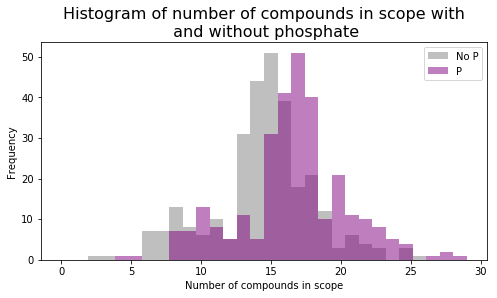

In [56]:
ax = pnp_df[['No P','P']].plot.hist(alpha=.5,bins=30,legend=True,color=['grey','purple'],figsize=(8,4))
ax.set_title("Histogram of number of compounds in scope with\n and without phosphate",fontsize=16)
ax.set_xlabel("Number of compounds in scope")
# plt.

### Original figure below

Text(0.5, 0, 'Number of compounds in scope')

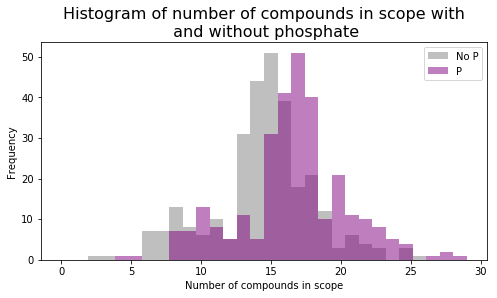

In [56]:
ax = pnp_df[['No P','P']].plot.hist(alpha=.5,bins=30,legend=True,color=['grey','purple'],figsize=(8,4))
ax.set_title("Histogram of number of compounds in scope with\n and without phosphate",fontsize=16)
ax.set_xlabel("Number of compounds in scope")
# plt.

In [57]:
pd.pivot_table(merged_df_nophosphorous[['domain','n_scope_targets']],columns=["domain"])

domain,archaea,bacteria
n_scope_targets,50.785714,58.492481


In [58]:
merged_df_nophosphorous.head()

,n_compounds_cumulative,n_targets_cumulative,org_id,domain,n_scope_targets,n_scope_compounds,P
156,19,0,2554235157,bacteria,60,1861,False
28,17,0,2517287020,bacteria,60,1809,False
21,17,0,2515154141,bacteria,60,1786,False
20,16,0,2515154140,bacteria,60,1767,False
277,25,0,640753051,bacteria,60,1701,False


In [59]:
scope_targets_df = pd.DataFrame()

In [60]:
scope_targets_df["archaea"] = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_targets"]

In [61]:
# merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"]

In [62]:
scope_targets_df["bacteria"] = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"]

In [63]:
len(scope_targets_df)

28

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 0, 'Number of compounds in target set')

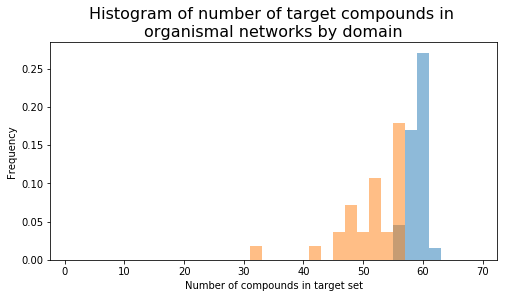

In [64]:
ax = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"].plot.hist(alpha=.5,bins=range(1,70,2),normed=True,legend=False,figsize=(8,4))
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_targets"].plot.hist(alpha=.5,bins=range(1,70,2),normed=True,legend=False)

ax.set_title("Histogram of number of target compounds in \norganismal networks by domain",fontsize=16)
ax.set_xlabel("Number of compounds in target set")

In [65]:
range(1,65,5)

range(1, 65, 5)

/Users/anarres/Library/Python/3.7/lib/python/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



Text(0.5, 0, 'Number of compounds')

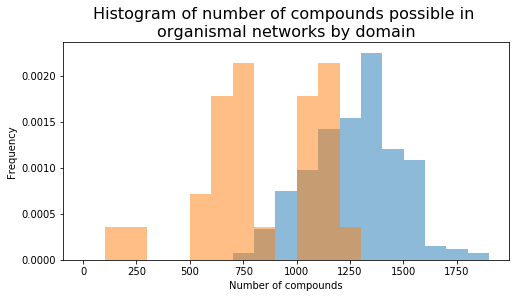

In [66]:
ax = merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,figsize=(8,4),legend=False)
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="archaea"]["n_scope_compounds"].plot.hist(alpha=.5,bins=range(1,2000,100),normed=True,legend=False)

ax.set_title("Histogram of number of compounds possible in \norganismal networks by domain",fontsize=16)
ax.set_xlabel("Number of compounds")

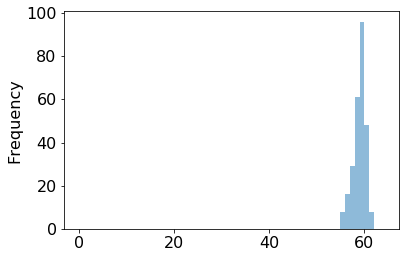

In [361]:
merged_df_nophosphorous.loc[merged_df_nophosphorous["domain"]=="bacteria"]["n_scope_targets"].plot.hist(alpha=.5,bins=range(65),legend=False)


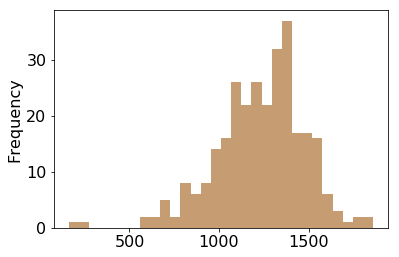

In [307]:
pnp_df[['n_scope_compounds','n_scope_compounds_P']].plot.hist(alpha=.5,bins=30,legend=False)

In [ ]:
pnp_df[['n_compounds_cumulative','n_scope_targets','n_scope_compounds']].hist(alpha=.5,bins=50)

In [176]:
stats_dicts[0].keys()

['domain',
 u'scope_seeds',
 u'scope_targets',
 'org_id',
 u'scope_compounds',
 'path',
 u'scope_reactions']

(array([   2.,    0.,    2.,   13.,   46.,  173.,   23.,   12.,   14.,    9.]),
 array([  3. ,   4.2,   5.4,   6.6,   7.8,   9. ,  10.2,  11.4,  12.6,
         13.8,  15. ]),
 <a list of 10 Patch objects>)

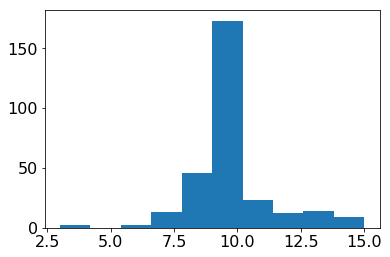

In [177]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([   1.,    0.,    0.,    1.,    2.,    4.,    8.,   19.,  107.,  152.]),
 array([ 32. ,  34.9,  37.8,  40.7,  43.6,  46.5,  49.4,  52.3,  55.2,
         58.1,  61. ]),
 <a list of 10 Patch objects>)

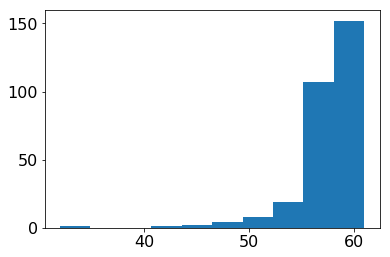

In [178]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([  2.,   0.,   4.,  15.,  28.,  64.,  80.,  71.,  25.,   5.]),
 array([  161.,   331.,   501.,   671.,   841.,  1011.,  1181.,  1351.,
         1521.,  1691.,  1861.]),
 <a list of 10 Patch objects>)

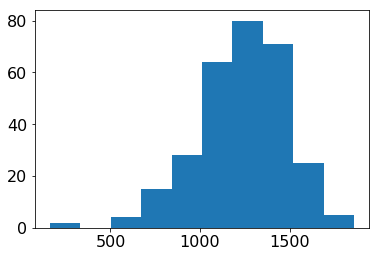

In [179]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([  2.,   2.,   7.,   8.,  26.,  67.,  64.,  80.,  33.,   5.]),
 array([   85. ,   247.2,   409.4,   571.6,   733.8,   896. ,  1058.2,
         1220.4,  1382.6,  1544.8,  1707. ]),
 <a list of 10 Patch objects>)

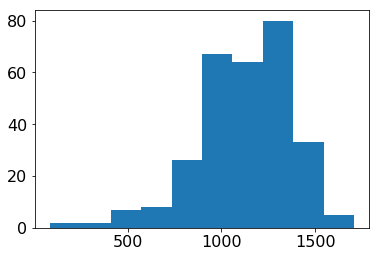

In [180]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

In [181]:
# cool_plots_many(df,'n_compounds_new')

In [182]:
# cool_plots_many(df,'n_compounds_cumulative')

In [183]:
# cool_plots_many(df,'n_targets_cumulative')

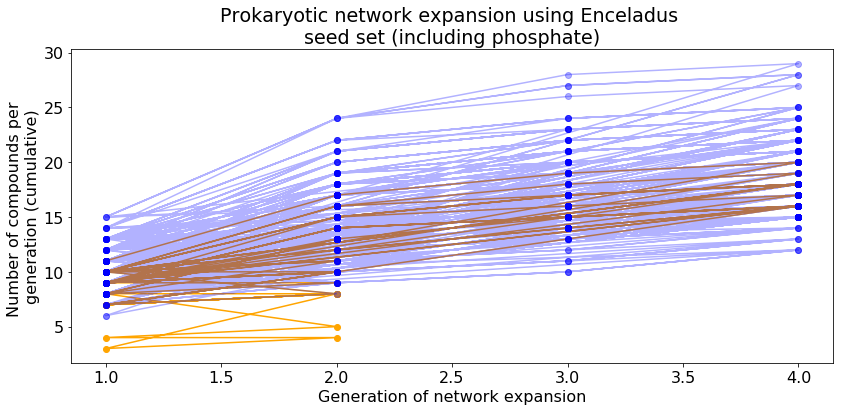

In [186]:
ax = df.loc[df["domain"]=="archaea"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="orange",figsize=(12,6),legend=False)
df.loc[df["domain"]=="bacteria"].reset_index().plot(kind="line",x="index",y="n_compounds_cumulative", style='-o',color="blue",ax=ax, alpha=.3,legend=False)

ax.set_title("Prokaryotic network expansion using Enceladus \nseed set (including phosphate)")
ax.set_xlabel("Generation of network expansion")
ax.set_ylabel("Number of compounds per \ngeneration (cumulative)")
plt.tight_layout()

## Using all KEGGs reactions

In [205]:
INDIR = "../results/formatted/kegg_edge_json_P/"

generation_dfs, stats_dicts = read_formatted_json_single(INDIR)
# print len(generation_dfs)
generation_dfs = twist_dfs(generation_dfs)
generation_dfs = add_n_to_cols(generation_dfs)
# generation_dfs = add_tags(generation_dfs,cpds_to_tag)
generation_dfs = add_domain_and_orgid(generation_dfs,stats_dicts)
df = generation_dfs[0]

In [206]:
len(stats_dicts[0])

7

In [207]:
df.head()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
1,"[C00001, C00009, C01326, C00132, C00067, C0001...","[C06547, C20783, C01548, C00014, C00011, C0006...","[R10092, R05539, R09139, R00067, R00132, R0235...","[R10535, R10079, R10092, R00131, R09139, R0000...",[],[],19,19,24,24,0,0,reaction_edges_P,bacteria
2,"[C00001, C00080, C00007, C00026, C00009, C0132...","[C00080, C00007, C00026, C00013, C00288, C0535...","[R10092, R00608, R05539, R00279, R00748, R0013...","[R00608, R00279, R00748, R00138, R03546, R0914...",[],[],43,24,64,40,0,0,reaction_edges_P,bacteria
3,"[C00001, C00080, C00007, C00026, C00009, C0004...","[C00048, C00025, C00704, C00022, C00346, C0022...","[R00782, R10092, R06870, R00608, R00258, R0553...","[R00782, R06870, R00258, R08886, R00475, R0000...",[C00025],[C00025],73,30,164,100,1,1,reaction_edges_P,bacteria
4,"[C00001, C00080, C00007, C00026, C00009, C0004...","[C02798, C00036, C00546, C00097, C00037, C0006...","[R00340, R04051, R00363, R00782, R10092, R1017...","[R00340, R04051, R00363, R10178, R02914, R0727...","[C00025, C00097, C00037, C00065, C00064, C00041]","[C00097, C00037, C00065, C00064, C00041]",162,89,326,162,6,5,reaction_edges_P,bacteria
5,"[C00001, C00080, C00007, C02107, C00026, C0000...","[C02107, C03826, C00383, C02091, C00108, C0095...","[R00340, R09186, R10908, R03106, R03551, R0405...","[R09186, R10908, R03106, R03551, R03694, R0696...","[C00025, C00097, C00037, C00065, C00064, C0004...","[C00049, C00188]",271,109,455,129,8,2,reaction_edges_P,bacteria


(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 18.5,  18.6,  18.7,  18.8,  18.9,  19. ,  19.1,  19.2,  19.3,
         19.4,  19.5]),
 <a list of 10 Patch objects>)

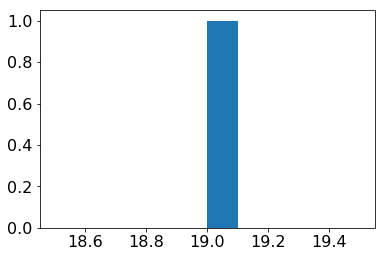

In [208]:
plt.hist([len(d['scope_seeds']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 62.5,  62.6,  62.7,  62.8,  62.9,  63. ,  63.1,  63.2,  63.3,
         63.4,  63.5]),
 <a list of 10 Patch objects>)

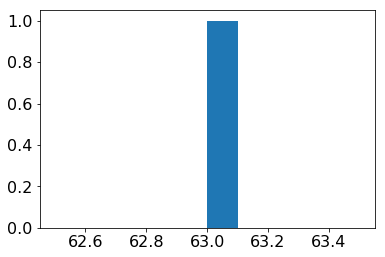

In [209]:
plt.hist([len(d['scope_targets']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 8278.5,  8278.6,  8278.7,  8278.8,  8278.9,  8279. ,  8279.1,
         8279.2,  8279.3,  8279.4,  8279.5]),
 <a list of 10 Patch objects>)

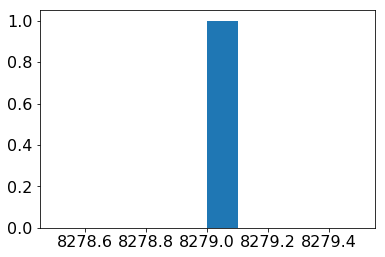

In [210]:
plt.hist([len(d['scope_compounds']) for d in stats_dicts])

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 10286.5,  10286.6,  10286.7,  10286.8,  10286.9,  10287. ,
         10287.1,  10287.2,  10287.3,  10287.4,  10287.5]),
 <a list of 10 Patch objects>)

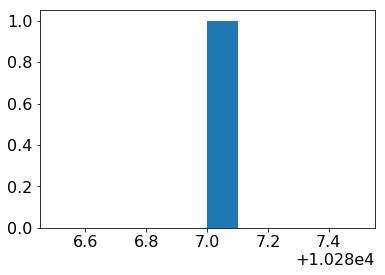

In [211]:
plt.hist([len(d['scope_reactions']) for d in stats_dicts])

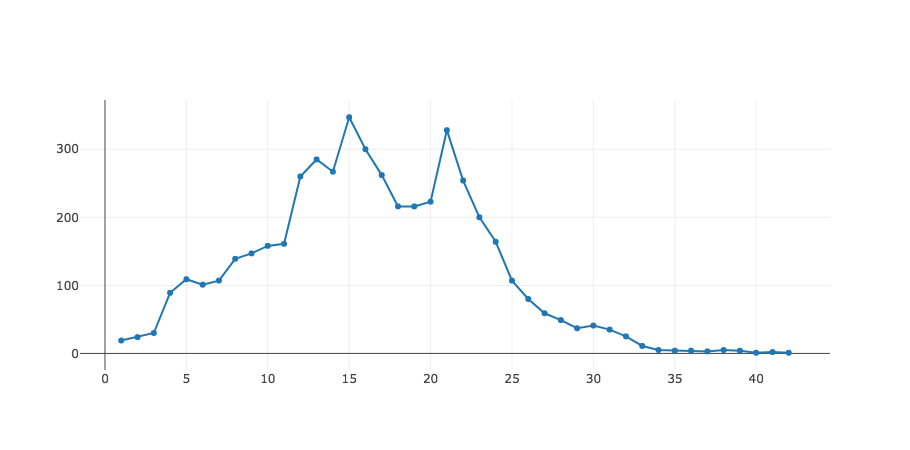

In [212]:
cool_plots_many(df,'n_compounds_new')

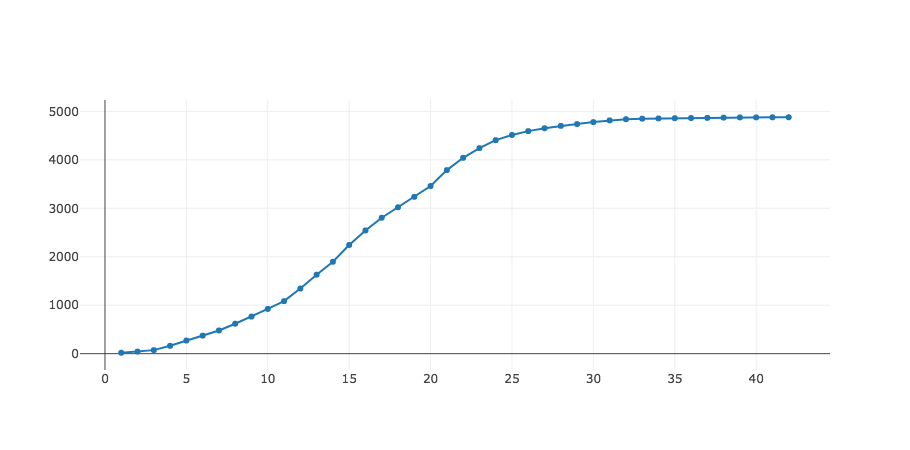

In [213]:
cool_plots_many(df,'n_compounds_cumulative')

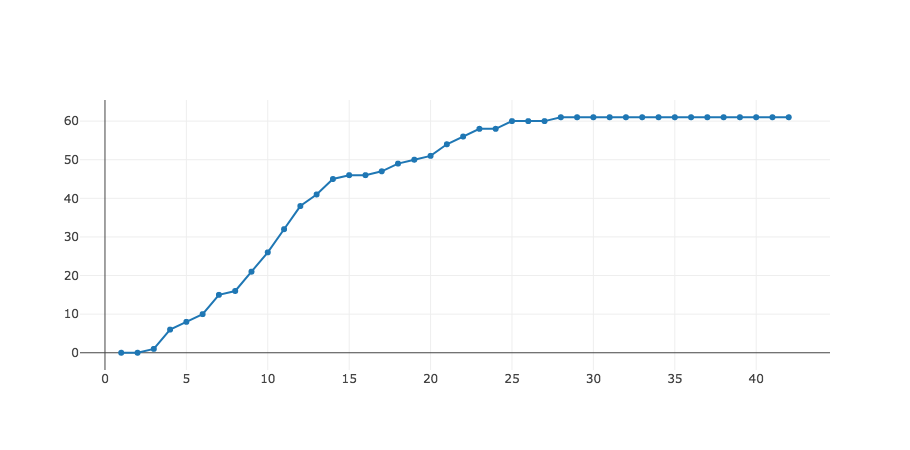

In [214]:
cool_plots_many(df,'n_targets_cumulative')

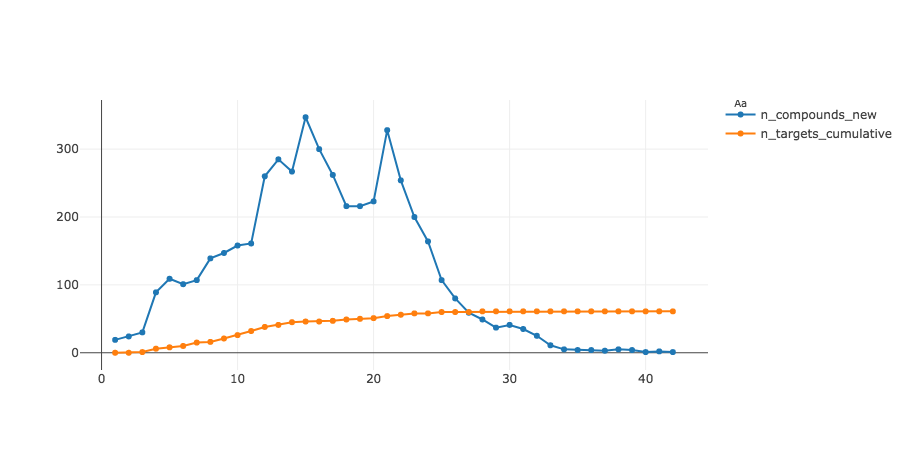

In [215]:
cool_plots(df,'n_compounds_new','n_targets_cumulative')

Text(0.5,0,'Generation of network expansion')

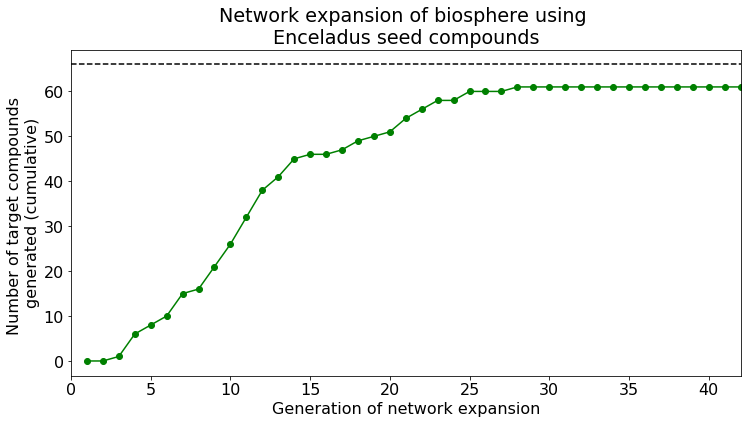

In [216]:
ax = df.reset_index().plot(kind="line",x="index",y="n_targets_cumulative",style='-o',legend=False,figsize=(12,6),c='g')
plt.axhline(y=66,c='k',linestyle='--')

ax.set_xlim(0,42)
ax.set_title("Biosphere network expansion using Enceladus seed set (including phosphate)")
ax.set_ylabel("Number of target compounds \ngenerated (cumulative)")
ax.set_xlabel("Generation of network expansion")


In [118]:
print 1

1


In [79]:
df.tail()

,compounds_cumulative,compounds_new,reactions_cumulative,reactions_new,targets_cumulative,targets_new,n_compounds_cumulative,n_compounds_new,n_reactions_cumulative,n_reactions_new,n_targets_cumulative,n_targets_new,org_id,domain
38,"[C01832, C00016, C00422, C00001, C17224, C0002...","[C19586, C16756, C16339, C19585, C19595]","[R03857, R02250, R08640, R00340, R02433, R0108...","[R09409, R09410, R09406, R07902]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],4871,5,6853,4,61,0,reaction_edges_P,bacteria
39,"[C01832, C00016, C00422, C00001, C17224, C0002...","[C19588, C11278, C19594, C16317]","[R03857, R02250, R08640, R00340, R02433, R0108...",[R09411],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],4875,4,6854,1,61,0,reaction_edges_P,bacteria
40,"[C01832, C00016, C00422, C00001, C17224, C0002...",[C19589],"[R03857, R02250, R08640, R00340, R02433, R0108...","[R09413, R09412]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],4876,1,6856,2,61,0,reaction_edges_P,bacteria
41,"[C01832, C00016, C00422, C00001, C17224, C0002...","[C19592, C19591]","[R03857, R02250, R08640, R00340, R02433, R0108...","[R09415, R09414]","[C00016, C00024, C00005, C00003, C00035, C0000...",[],4878,2,6858,2,61,0,reaction_edges_P,bacteria
42,"[C01832, C00016, C00422, C00001, C17224, C0002...",[C19590],"[R03857, R02250, R08640, R00340, R02433, R0108...",[],"[C00016, C00024, C00005, C00003, C00035, C0000...",[],4879,1,6858,0,61,0,reaction_edges_P,bacteria


In [86]:
targets_Freilich09=["C00001",
    "C00002",
    "C00003",
    "C00004",
    "C00005",
    "C00006",
    "C00008",
    "C00015",
    "C00016",
    "C00020",
    "C00024",
    "C00025",
    "C00035",
    "C00037",
    "C00041",
    "C00043",
    "C00044",
    "C00047",
    "C00049",
    "C00054",
    "C00055",
    "C00062",
    "C00063",
    "C00064",
    "C00065",
    "C00073",
    "C00075",
    "C00078",
    "C00079",
    "C00082",
    "C00097",
    "C00105",
    "C00112",
    "C00116",
    "C00123",
    "C00131",
    "C00135",
    "C00144",
    "C00148",
    "C00152",
    "C00183",
    "C00188",
    "C00234",
    "C00239",
    "C00249",
    "C00255",
    "C00286",
    "C00350",
    "C00360",
    "C00362",
    "C00364",
    "C00399",
    "C00407",
    "C00458",
    "C00459",
    "C00641",
    "C00748",
    "C01050",
    "C05764",
    "C05890",
    "C05894",
    "C05899",
    "C05980",
    "C06040",
    "C15672",
    "C16221"]

In [87]:
kegg_targets_cumulative = df.iloc[41]["targets_cumulative"]

In [90]:
# df.iloc[41]["targets_cumulative"]

[u'C00016',
 u'C00024',
 u'C00005',
 u'C00003',
 u'C00035',
 u'C00002',
 u'C00025',
 u'C00004',
 u'C00008',
 u'C00006',
 u'C00063',
 u'C00097',
 u'C00037',
 u'C00065',
 u'C00064',
 u'C00044',
 u'C00082',
 u'C00148',
 u'C00152',
 u'C00047',
 u'C00123',
 u'C00135',
 u'C00020',
 u'C00078',
 u'C00183',
 u'C00041',
 u'C00079',
 u'C00062',
 u'C01050',
 u'C00350',
 u'C00055',
 u'C00407',
 u'C00043',
 u'C00249',
 u'C00049',
 u'C00015',
 u'C00188',
 u'C00364',
 u'C00458',
 u'C00075',
 u'C05764',
 u'C00131',
 u'C00234',
 u'C00239',
 u'C00641',
 u'C00073',
 u'C00255',
 u'C00286',
 u'C00116',
 u'C05894',
 u'C00144',
 u'C00399',
 u'C00112',
 u'C05980',
 u'C00105',
 u'C00360',
 u'C00459',
 u'C00362',
 u'C00054',
 u'C06040',
 u'C16221']

In [89]:
set(targets_Freilich09) - set(kegg_targets_cumulative)

{'C00001', 'C00748', 'C05890', 'C05899', 'C15672'}

> KEGG Doesn't even have C05890 C05899 in Current version Oct 12
> The expansion is missing Siroheme, a large compound found in Porphyrin and chlorophyll metabolism, Metabolic pathways, Biosynthesis of secondary metabolites; Heme, a coenzyme common in metabolism. 
